<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose3 in colab with a GPU

<font size = 4>Cellpose3 now allows you to restore and segment noisy/blurry/low res images!

For more details on Cellpose3 check out the [paper](https://www.biorxiv.org/content/10.1101/2024.02.10.579780v1).

Mount your google drive to access all your image files. This also ensures that the segmentations are saved to your google drive.

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [13]:
!pip install "opencv-python"
!pip install cellpose

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [14]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Wed Apr 16 16:28:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0       

## Mount Google Drive to load images

In [15]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Previsualise images (optional)

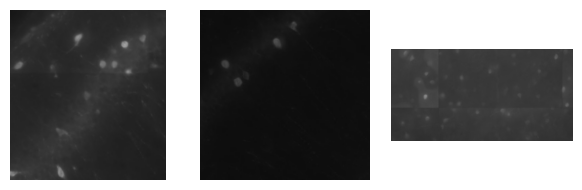

In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob
from cellpose.io import imread

# For inline plotting
%matplotlib inline
mpl.rcParams['figure.dpi'] = 100  # lower resolution for faster rendering

# Path to your image folder
image_dir = "/content/drive/Othercomputers/Colab/test2"

# Load all .tif and .tiff files
image_files = sorted(glob(os.path.join(image_dir, "*.tif")) +
                     glob(os.path.join(image_dir, "*.tiff")))

# Read the images
imgs = [imread(f) for f in image_files]

# Show all images (adjust grid size dynamically)
n_images = len(imgs)
cols = 5
rows = (n_images + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))  # Adjust size as needed
for i, img in enumerate(imgs):
    img = img.squeeze()
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Run segmentation and plot results

INFO: ** TORCH CUDA version installed and working. **
INFO: >>>> using GPU (CUDA)
INFO: >>>> loading model /content/drive/Othercomputers/Colab/Cellpose/CP_all_DMaps_v2
INFO: >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO: >>>> model diam_labels =  12.891 (mean diameter of training ROIs)
Processing: /content/drive/Othercomputers/Colab/test2/2025-04-10-11.03.29 ZS DMap.tif


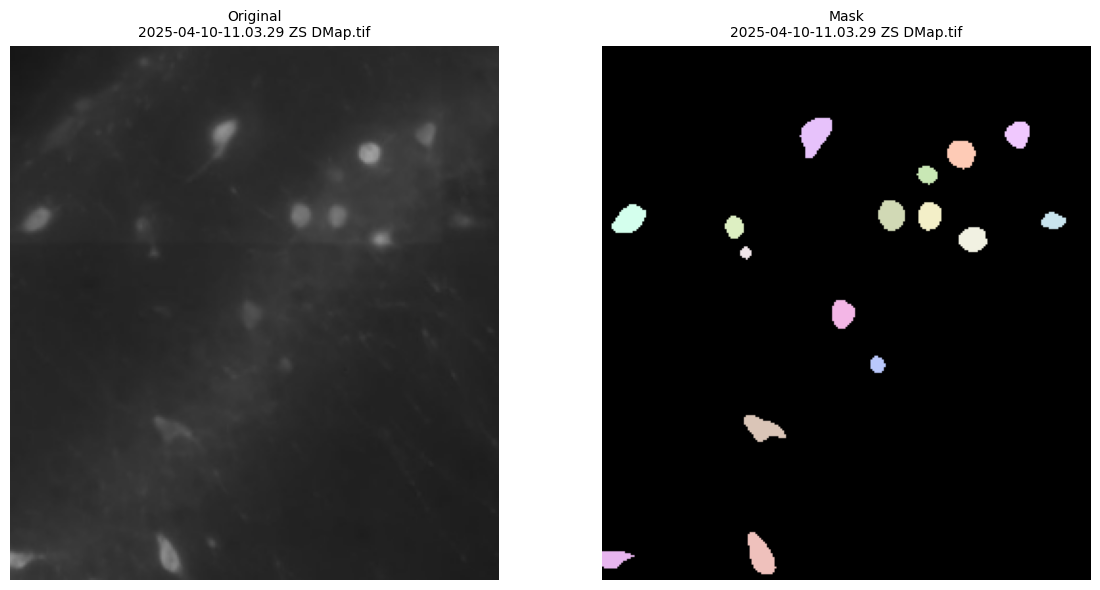

Processing: /content/drive/Othercomputers/Colab/test2/26.tif


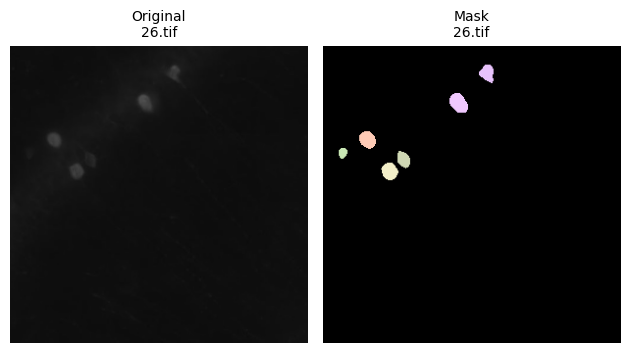

Processing: /content/drive/Othercomputers/Colab/test2/42.tif


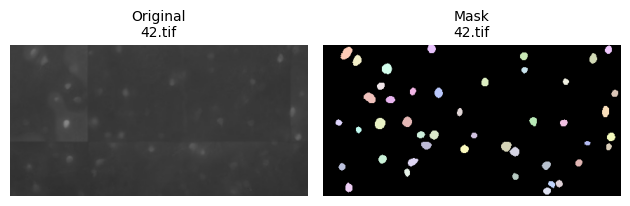

In [47]:
import os
import glob
import gc
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
from cellpose.io import imread

# --- CONFIG ---
image_dir = "/content/drive/Othercomputers/Colab/test2"
model_path = "/content/drive/Othercomputers/Colab/Cellpose/CP_all_DMaps_v2"

# --- FILES & MODEL ---
files_list = sorted(glob.glob(os.path.join(image_dir, '*.tif')) +
                    glob.glob(os.path.join(image_dir, '*.tiff')))
channels = [[0, 0]] * len(files_list)
model = models.CellposeModel(pretrained_model=model_path, gpu=True)

# --- Colored RGB mask generator ---
def color_mask_rgb(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    np.random.seed(42)  # Consistent colors per run
    for lbl in np.unique(mask):
        if lbl == 0:
            continue
        color = np.random.randint(180, 256, size=3)  # light color
        rgb[mask == lbl] = color
    return rgb

# --- Plotting setup ---
plt.figure(figsize=(12, 6))

# --- Main loop ---
for chan, filename in zip(channels, files_list):
    try:
        print(f"Processing: {filename}")
        img = imread(filename)
        masks, flows, styles = model.eval(img, diameter=None, channels=chan)

        # Save outputs
        io.masks_flows_to_seg(img, masks, flows, filename, channels=chan, diams=None)
        io.save_rois(masks, os.path.join(image_dir, os.path.basename(filename) + "_rois"))

        # Create colored RGB mask (without black border)
        mask_rgb = color_mask_rgb(masks)

        # Plot
        plt.clf()
        plt.subplot(1, 2, 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(f"Original\n{os.path.basename(filename)}", fontsize=10)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask_rgb)
        plt.title(f"Mask\n{os.path.basename(filename)}", fontsize=10)
        plt.axis('off')

        plt.tight_layout()
        plt.draw()
        plt.pause(1)

        del img, masks, flows, styles, mask_rgb
        gc.collect()

    except Exception as e:
        print(f"Error processing {filename}: {e}")

plt.show()
